## Visualize markers from Robin

In [24]:
class Parameter:
    cams, planes = [0,1,2,3], [1,2,3,4,5,6,12,13,14,15,16,17,18,19,20,21,22,23]
    
    marker_distance, Z0 = (40,40), 0 # X[mm], Y[mm], Z[mm]
    marker_size = (25, 19)  # x, y
    image_size = (2560, 2048)  # x[px], y[px]
    
    Zeros = 2
    markerList = "Ilmenau_xy/c{cam}/marker/c{cam}_{plane}.txt" 
    markerImage = "Ilmenau_xy/c{cam}/c{cam}_{plane}_01.tif"
    markerOutput = "c{cam}_xyXYZ.txt"

In [25]:
def DLT(P1, P2, P3, P4, xy1, xy2, xy3, xy4):
    """
    Args:
        P1, P2, P3, P4: 3x4 projection matrices for cameras i in (1, 2, 3, 4) so that: xy_i = P_i * XYZ and XYZ=(X,Y,Z,1)
        xy1, xy2, xy3, xy4: 2D image points (x, y) for each camera
    
    Returns:
        3D point (X, Y, Z) in world coordinates
    Meaning:
        Perform DLT with 4 cameras to reconstruct a 3D point with projection matrices of cameras 2,3,4: P2,P3,P4, relative to camera 1.
        The system solves the homogeneous system A * XYZ = 0.
        From a pinhole model we know that xy_i = P_i * XYZ with xy_i = [x',y',w] and x=x'/w and y=y'/w building 2 equations for each camera: 
                x_i = (P_i*XYZ)_row1 / (P_i*XYZ)_raw3  -> (x_i*P_i_raw1 - P_i_raw3) * XYZ = 0
                y_i = (P_i*XYZ)_row2 / (P_i*XYZ)_raw3  -> (y_i*P_i_raw2 - P_i_raw3) * XYZ = 0
        This we can build matrix the matrix equation A * XYZ = 0 using all four cameras and the two equations above for each of them.
        Due to noise we do not have A*XYZ=0 instead we have A*XYZ\approx 0 with an non-trivial solution XYZ!=0.
        To find the correct solution we use SVD
        SVD decomposes A = U S V^T, where S is diagonal with singular values.
        The solution we need is the singular vector V_T which corresponding to the smallest singular value (i.e. the last one in numpys output)
        This value minimizes A*XYZ.
    """
    # Construct the 8x4 matrix A using equations from all 4 cameras
    A = np.vstack([
        xy1[1] * P1[2, :] - P1[1, :],  # y1 * P1_3 - P1_2
        P1[0, :] - xy1[0] * P1[2, :],  # P1_1 - x1 * P1_3
        xy2[1] * P2[2, :] - P2[1, :],  # y2 * P2_3 - P2_2
        P2[0, :] - xy2[0] * P2[2, :],  # P2_1 - x2 * P2_3
        xy3[1] * P3[2, :] - P3[1, :],  # y3 * P3_3 - P3_2
        P3[0, :] - xy3[0] * P3[2, :],  # P3_1 - x3 * P3_3
        xy4[1] * P4[2, :] - P4[1, :],  # y4 * P4_3 - P4_2
        P4[0, :] - xy4[0] * P4[2, :]]) # P4_1 - x4 * P4_3
    # Solve using Singular Value Decomposition (SVD)
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    # The corrct 3D point is the last column of Vh 
    XYZ = Vh[-1, 0:3] / Vh[-1, 3]  # Normalize by the homogeneous coordinate
    return XYZ

In [26]:

# from multiview_calibration import DLT, Parameter

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly 

# copy of main()
# load parameters 
params = Parameter()    

# define first plane XYZ as reference with Z = 0
X, Y, Z = np.meshgrid(np.arange(0,params.marker_size[0]*params.marker_distance[0],params.marker_distance[0]),
                        -np.arange(0,params.marker_size[1]*params.marker_distance[1],params.marker_distance[1]),
                        np.linspace(params.Z0,params.Z0,1))
# initalize a XYZ plane for each plane position equal to the first plane with Z=0
# we dont know the exact 3D XYZ position of the planes yet
XYZ = [np.asarray(np.vstack([X.ravel(),Y.ravel(),Z.ravel()]).T, dtype=np.float32) for plane in params.planes]

# calibrate cameras individually
xy_c, P_c, R_c, ret_c, M_c, d_c, r_c, t_c, pos_c = [], [], [], [], [], [], [], [], []
for i,c in enumerate(params.cams):
    xy = [np.asarray(np.loadtxt(params.markerList.format(cam=c,plane=str(t).zfill(params.Zeros)),skiprows=1), dtype=np.float32) for t in params.planes]
    xy_c.append(xy)
    ret, M, d, r, t = cv2.calibrateCamera(XYZ,xy,params.image_size,None,None) 
    ret_c.append(ret), M_c.append(M), d_c.append(d), r_c.append(r), t_c.append(t)
    # estimate rotation matrix
    R = cv2.Rodrigues(r[0])[0] 
    R_c.append(R)
    # estimate camera position
    pos = -np.dot(R.T, t[0]).ravel()
    pos_c.append(pos)
    # build projection matizes relative to camera 0 
    if i==0: # projection matrix for camera 0
        RT = np.concatenate([R, t[0]], axis=-1)
        P_c.append(M @ RT)
    else: # projection matrix relative to camera 0 for camera 1, 2 and 3
        # stereo matching of the FIRST 3D marker plane - use only cam 0 and cam i with i in (1,2,3)
        # the assumption of straight lines for light rays inside the medium is needed here because only the first plane 3D positions are known
        ret, CM0, dist0, CM1, dist1, R, T, E, F = cv2.stereoCalibrate(XYZ[:1], xy_c[0][:1], xy_c[i][:1], M_c[0], d_c[0], M_c[i], d_c[i], params.image_size)
        # projection matrix for camera i with respect to camera 0
        RT = np.concatenate([R@R_c[0], (R@t_c[0][0]+T)], axis = -1)
        P_c.append(M @ RT)
# compute 3D marker positions using all cameras and the DLT algorithm
P = []
for p in tqdm(range(len(params.planes)),desc='DLT'):
    # For each plane, reconstruct 3D points using corresponding 2D points from all 4 cameras
    markers_p = []
    for xy0, xy1, xy2, xy3 in zip(xy_c[0][p], xy_c[1][p], xy_c[2][p], xy_c[3][p]):
        markers_p.append( DLT(P_c[0], P_c[1], P_c[2], P_c[3], xy0, xy1, xy2, xy3) )
    P.append(np.asarray(markers_p,dtype=np.float32))
P[0] = XYZ[0]
# recalibrate cameras with the reconstructed XYZ points of all plates
for i,c in enumerate(params.cams):
    ret, M, d, r, t = cv2.calibrateCamera(P,xy_c[i],params.image_size,M_c[i],d_c[i],flags=cv2.CALIB_USE_INTRINSIC_GUESS) 
    ret_c[i], M_c[i], d_c[i], r_c[i], t_c[i] = ret, M, d, r, t
    R = cv2.Rodrigues(r[0])[0] 
    R_c[i] = R
    pos = -np.dot(R.T, t[0]).ravel()
    pos_c[i] = pos
    print('position cam '+str(c)+': ', pos)
        
# save out Soloff dataset which is the xyXYZ list for each camera containing all planes
for c in range(len(params.cams)):
    xyXYZ = np.concatenate([np.append(xy_c[c][i],P[i],axis=1) for i in range(len(params.planes))])
    np.savetxt(params.markerOutput.format(cam=str(params.cams[c])), xyXYZ, header='x,y,X,Y,Z')


DLT: 100%|██████████| 18/18 [00:00<00:00, 39.70it/s]


position cam 0:  [ 1917.18352282   481.83027811 -3107.70793108]
position cam 1:  [ 1918.07916451 -1385.52866869 -3038.49202608]
position cam 2:  [ -910.17652452   458.74238092 -3133.90152874]
position cam 3:  [ -852.17828192 -1360.45371599 -3072.23731727]


In [27]:
import numpy as np

def get_openptv_intrinsics(camera_matrix, image_size, pixel_size_mm):
    """
    Converts OpenCV intrinsic parameters to the OpenPTV format.

    Args:
        camera_matrix (np.ndarray): The 3x3 camera matrix from cv2.calibrateCamera().
        image_size (tuple): The image size (width, height) in pixels.
        pixel_size_mm (float): The physical size of a single pixel in millimeters.

    Returns:
        tuple: A tuple containing (f_mm, xp_mm, yp_mm).
    """
    # 1. Extract focal length and principal point in pixels from the camera matrix
    fx_px = camera_matrix[0, 0]
    fy_px = camera_matrix[1, 1]
    cx_px = camera_matrix[0, 2]
    cy_px = camera_matrix[1, 2]

    # 2. Calculate the back focal distance in mm
    # We assume square pixels, so we can average fx and fy.
    # If your pixels are not square, you would need separate pixel_size_x and pixel_size_y.
    f_mm = ((fx_px + fy_px) / 2.0) * pixel_size_mm

    # 3. Calculate the principal point offset in mm from the image center
    image_width_px, image_height_px = image_size
    center_x_px = image_width_px / 2.0
    center_y_px = image_height_px / 2.0

    # Calculate the offset in pixels from the center
    offset_x_px = cx_px - center_x_px
    offset_y_px = cy_px - center_y_px # Note: Y points down in image coordinates

    # Convert the offset to millimeters
    # OpenPTV typically expects a standard coordinate system where Y is up,
    # but the principal point offset calculation remains the same.
    # The sign convention will depend on the exact definition in your OpenPTV version.
    # A positive yp often means the principal point is 'above' the center.
    xp_mm = offset_x_px * pixel_size_mm
    yp_mm = offset_y_px * pixel_size_mm 

    return f_mm, xp_mm, yp_mm

In [28]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R

def convert_to_openptv_format(rvec, tvec):
    """
    Converts a single OpenCV rotation and translation vector into
    the OpenPTV format (x, y, z, omega, phi, kappa).

    Args:
        rvec (np.ndarray): A single rotation vector (3x1) from OpenCV.
        tvec (np.ndarray): A single translation vector (3x1) from OpenCV.

    Returns:
        tuple: A tuple containing (x, y, z, omega, phi, kappa).
               Angles are in radians, which is standard for OpenPTV.
    """
    # 1. Convert rotation vector to a 3x3 rotation matrix.
    # This matrix describes the orientation of the world coordinate system
    # relative to the camera coordinate system.
    rotation_matrix_world_to_cam, _ = cv2.Rodrigues(rvec)

    # 2. Invert the transformation to get the camera's pose in world coordinates.
    # The camera's orientation is the transpose of the above matrix.
    rotation_matrix_cam_to_world = rotation_matrix_world_to_cam.T
    
    # The camera's position is the negative of the rotated translation vector.
    camera_position = -np.dot(rotation_matrix_cam_to_world, tvec)

    # 3. Apply a coordinate system transformation.
    # OpenCV's camera has Y pointing down. A standard photogrammetric
    # frame has Y pointing up. We apply a 180-degree rotation around the X-axis
    # to the camera's orientation to correct this.
    coord_system_transform = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    final_rotation_matrix = np.dot(coord_system_transform, rotation_matrix_cam_to_world)

    # 4. Decompose the final rotation matrix into Euler angles.
    # We use scipy's Rotation class for a robust conversion.
    # The order 'xyz' corresponds to rotations around X, then Y, then Z.
    # These correspond to omega, phi, and kappa respectively.
    # Note: Your term 'gamma' is commonly referred to as 'phi' (rotation around Y-axis).
    r = R.from_matrix(final_rotation_matrix)
    omega, phi, kappa = r.as_euler('xyz', degrees=False)

    # Return the camera position and angles.
    x, y, z = camera_position.ravel()
    return x, y, z, omega, phi, kappa

In [29]:
# --- Your existing code with modifications ---
# Make sure the arrays like R_c, pos_c, etc., are initialized before the loop.
# =========================================================================
# IMPORTANT: YOU MUST DEFINE YOUR CAMERA'S PHYSICAL PARAMETERS HERE
# =========================================================================
# Find this in your camera's datasheet. Example: 3.45 micrometers -> 0.00345 mm
PIXEL_SIZE_MM = 0.005 


for i, c in enumerate(params.cams):
    # Perform the calibration as before
    ret, M, d, r, t = cv2.calibrateCamera(P, xy_c[i], params.image_size, M_c[i], d_c[i], flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    
    # Store the intrinsic parameters
    ret_c[i], M_c[i], d_c[i] = ret, M, d
    
    # Check if the calibration was successful before proceeding
    if ret:
        # As noted, we use the first calibration pattern view (r[0], t[0])
        # to define the camera's extrinsic parameters.
        rvec_for_cam = r[0]
        tvec_for_cam = t[0]
        
        # Store the raw rotation and translation vectors
        r_c[i] = r
        t_c[i] = t
        
        # --- NEW CONVERSION ---
        # Convert the OpenCV vectors to the OpenPTV x,y,z,omega,phi,kappa format
        x, y, z, omega, phi, kappa = convert_to_openptv_format(rvec_for_cam, tvec_for_cam)
        
        # You can now use or store these values
        pos_c[i] = np.array([x, y, z])
        # You might want to create a new array to store the angles, e.g., ang_c[i]
        
        # For compatibility with your old code, we can still store the rotation matrix
        R_c[i] = cv2.Rodrigues(rvec_for_cam)[0]

# --- INTRINSIC PARAMETERS (Focal Length and Principal Point) ---
        f_mm, xp_mm, yp_mm = get_openptv_intrinsics(M, params.image_size, PIXEL_SIZE_MM)
        
        # --- Print all results for this camera ---
        print(f"------ Camera {c} OpenPTV Parameters ------")
        print("Extrinsic Parameters:")
        print(f"  Position (x, y, z) [mm]:           ({x:.4f}, {y:.4f}, {z:.4f})")
        print(f"  Orientation (omega, phi, kappa) [rad]: ({omega:.4f}, {phi:.4f}, {kappa:.4f})")
        print("\nIntrinsic Parameters:")
        print(f"  Back Focal Distance (f) [mm]:      {f_mm:.4f}")
        print(f"  Principal Point Offset (xp, yp) [mm]: ({xp_mm:.4f}, {yp_mm:.4f})")
        print("-" * 40 + "\n")        
        
        # # --- Updated Printing ---
        # print(f"------ Camera {c} ------")
        # print(f"Position (x, y, z): ({x:.4f}, {y:.4f}, {z:.4f})")
        # print(f"Orientation (omega, phi, kappa) in radians: ({omega:.4f}, {phi:.4f}, {kappa:.4f})")
        # print("-" * 25)
        
    else:
        print(f"Calibration FAILED for camera {c}.")

------ Camera 0 OpenPTV Parameters ------
Extrinsic Parameters:
  Position (x, y, z) [mm]:           (1917.1835, 481.8303, -3107.7079)
  Orientation (omega, phi, kappa) [rad]: (-2.8536, 0.2406, -0.0490)

Intrinsic Parameters:
  Back Focal Distance (f) [mm]:      8.7902
  Principal Point Offset (xp, yp) [mm]: (-0.1341, -0.1689)
----------------------------------------

------ Camera 1 OpenPTV Parameters ------
Extrinsic Parameters:
  Position (x, y, z) [mm]:           (1915.4517, -1384.6799, -3031.8721)
  Orientation (omega, phi, kappa) [rad]: (2.8855, 0.2292, 0.0519)

Intrinsic Parameters:
  Back Focal Distance (f) [mm]:      8.7254
  Principal Point Offset (xp, yp) [mm]: (-0.0309, -0.1782)
----------------------------------------

------ Camera 2 OpenPTV Parameters ------
Extrinsic Parameters:
  Position (x, y, z) [mm]:           (-910.1765, 458.7424, -3133.9015)
  Orientation (omega, phi, kappa) [rad]: (-2.8511, -0.2195, -0.0038)

Intrinsic Parameters:
  Back Focal Distance (f) [mm]:


2D projection error
 Camera 0 - Plane 0
  Mean: 0.19  Max: 1.64  STD: 0.18


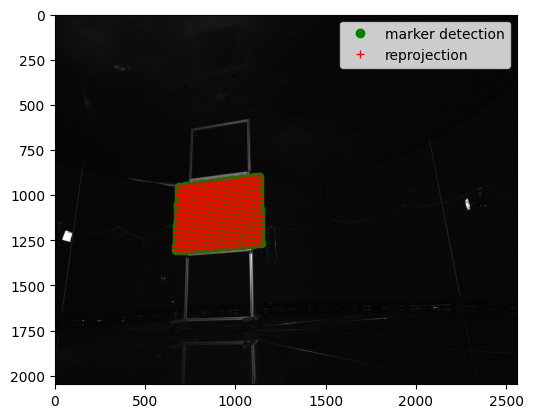


2D projection error
 Camera 0 - Plane 1
  Mean: 1.01  Max: 2.36  STD: 0.56

2D projection error
 Camera 0 - Plane 2
  Mean: 3.55  Max: 7.08  STD: 1.21

2D projection error
 Camera 0 - Plane 3
  Mean: 0.16  Max: 0.69  STD: 0.11

2D projection error
 Camera 0 - Plane 4
  Mean: 0.45  Max: 0.89  STD: 0.13

2D projection error
 Camera 0 - Plane 5
  Mean: 0.82  Max: 1.31  STD: 0.18

2D projection error
 Camera 0 - Plane 6
  Mean: 2.39  Max: 3.99  STD: 0.76

2D projection error
 Camera 0 - Plane 7
  Mean: 0.48  Max: 0.99  STD: 0.24

2D projection error
 Camera 0 - Plane 8
  Mean: 0.24  Max: 0.57  STD: 0.1

2D projection error
 Camera 0 - Plane 9
  Mean: 0.44  Max: 0.92  STD: 0.16

2D projection error
 Camera 0 - Plane 10
  Mean: 3.24  Max: 4.81  STD: 0.74

2D projection error
 Camera 0 - Plane 11
  Mean: 1.16  Max: 1.96  STD: 0.34

2D projection error
 Camera 0 - Plane 12
  Mean: 0.61  Max: 0.87  STD: 0.1

2D projection error
 Camera 0 - Plane 13
  Mean: 0.79  Max: 1.03  STD: 0.1

2D project

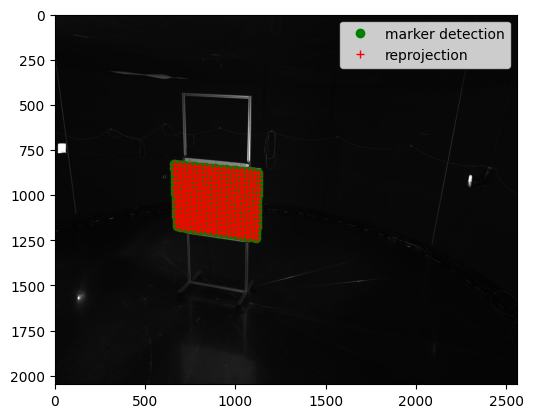


2D projection error
 Camera 1 - Plane 1
  Mean: 2.8  Max: 3.32  STD: 0.24

2D projection error
 Camera 1 - Plane 2
  Mean: 9.31  Max: 10.63  STD: 0.48

2D projection error
 Camera 1 - Plane 3
  Mean: 2.88  Max: 3.55  STD: 0.23

2D projection error
 Camera 1 - Plane 4
  Mean: 4.41  Max: 5.02  STD: 0.23

2D projection error
 Camera 1 - Plane 5
  Mean: 5.4  Max: 6.1  STD: 0.26

2D projection error
 Camera 1 - Plane 6
  Mean: 3.23  Max: 3.92  STD: 0.32

2D projection error
 Camera 1 - Plane 7
  Mean: 3.2  Max: 3.79  STD: 0.26

2D projection error
 Camera 1 - Plane 8
  Mean: 2.99  Max: 3.68  STD: 0.27

2D projection error
 Camera 1 - Plane 9
  Mean: 3.47  Max: 4.25  STD: 0.28

2D projection error
 Camera 1 - Plane 10
  Mean: 4.9  Max: 5.65  STD: 0.32

2D projection error
 Camera 1 - Plane 11
  Mean: 4.64  Max: 5.42  STD: 0.28

2D projection error
 Camera 1 - Plane 12
  Mean: 4.4  Max: 4.93  STD: 0.24

2D projection error
 Camera 1 - Plane 13
  Mean: 4.79  Max: 5.46  STD: 0.27

2D projectio

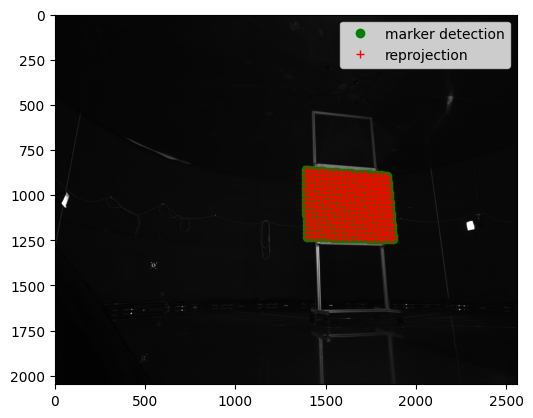


2D projection error
 Camera 2 - Plane 1
  Mean: 6.45  Max: 8.37  STD: 0.81

2D projection error
 Camera 2 - Plane 2
  Mean: 19.51  Max: 23.8  STD: 2.03

2D projection error
 Camera 2 - Plane 3
  Mean: 4.41  Max: 5.05  STD: 0.21

2D projection error
 Camera 2 - Plane 4
  Mean: 7.03  Max: 7.91  STD: 0.36

2D projection error
 Camera 2 - Plane 5
  Mean: 8.98  Max: 9.98  STD: 0.41

2D projection error
 Camera 2 - Plane 6
  Mean: 5.35  Max: 6.75  STD: 0.49

2D projection error
 Camera 2 - Plane 7
  Mean: 4.37  Max: 4.69  STD: 0.11

2D projection error
 Camera 2 - Plane 8
  Mean: 5.4  Max: 6.88  STD: 0.55

2D projection error
 Camera 2 - Plane 9
  Mean: 8.42  Max: 10.81  STD: 1.13

2D projection error
 Camera 2 - Plane 10
  Mean: 7.4  Max: 7.9  STD: 0.17

2D projection error
 Camera 2 - Plane 11
  Mean: 7.0  Max: 7.34  STD: 0.21

2D projection error
 Camera 2 - Plane 12
  Mean: 8.36  Max: 9.86  STD: 0.72

2D projection error
 Camera 2 - Plane 13
  Mean: 11.84  Max: 14.43  STD: 1.22

2D proj

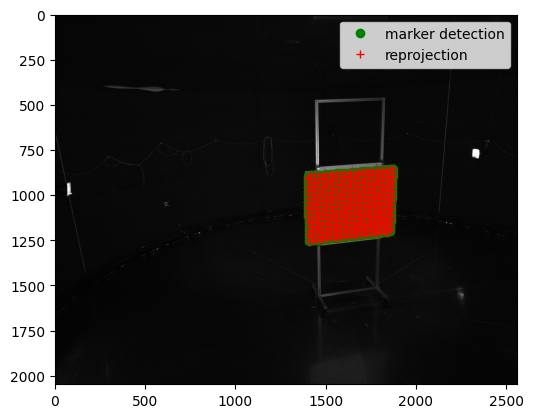


2D projection error
 Camera 3 - Plane 1
  Mean: 3.53  Max: 4.27  STD: 0.34

2D projection error
 Camera 3 - Plane 2
  Mean: 11.24  Max: 11.7  STD: 0.2

2D projection error
 Camera 3 - Plane 3
  Mean: 3.53  Max: 4.36  STD: 0.31

2D projection error
 Camera 3 - Plane 4
  Mean: 5.4  Max: 6.68  STD: 0.33

2D projection error
 Camera 3 - Plane 5
  Mean: 6.62  Max: 7.31  STD: 0.27

2D projection error
 Camera 3 - Plane 6
  Mean: 6.65  Max: 7.78  STD: 0.54

2D projection error
 Camera 3 - Plane 7
  Mean: 4.89  Max: 6.21  STD: 0.52

2D projection error
 Camera 3 - Plane 8
  Mean: 3.04  Max: 3.64  STD: 0.19

2D projection error
 Camera 3 - Plane 9
  Mean: 2.6  Max: 3.13  STD: 0.14

2D projection error
 Camera 3 - Plane 10
  Mean: 7.92  Max: 9.24  STD: 0.54

2D projection error
 Camera 3 - Plane 11
  Mean: 6.42  Max: 7.48  STD: 0.43

2D projection error
 Camera 3 - Plane 12
  Mean: 4.85  Max: 5.41  STD: 0.23

2D projection error
 Camera 3 - Plane 13
  Mean: 4.44  Max: 4.95  STD: 0.19

2D projec

In [30]:
# verify code and calculate some error metrics
'''HERE Chose which camera and which plane the metrics are calculated and plotted for'''
for c in range(len(params.cams)):
    for i in range(0,len(params.planes)):
        print('')
        print('2D projection error')
        # project xy = P*XYZ on camera i
        p, _ = cv2.projectPoints(P[i], r_c[c][0], t_c[c][0], M_c[c], d_c[c])
        p = p.reshape(int(params.marker_size[0]*params.marker_size[1]),2)
        # 2D error calculation
        error_xy = np.linalg.norm(xy_c[c][i]-p,axis=1)
        print(' Camera '+str(c)+' - Plane '+str(i)) 
        print('  Mean: '+str(np.round(np.mean(error_xy),2)), ' Max: '+str(np.round(np.max(error_xy),2)), ' STD: '+str(np.round(np.std(error_xy),2)))
        
        
        # plot 2D reprojection
        if i == 0:
            plt.figure()
            plt.imshow(cv2.imread(params.markerImage.format(cam=c,plane=str(params.planes[i]).zfill(params.Zeros)),cv2.IMREAD_UNCHANGED),cmap='gray')
            plt.plot(xy_c[c][i][:,0],xy_c[c][i][:,1],'o',c='green',label='marker detection')
            plt.plot(p[:,0],p[:,1],'+',c='red',label='reprojection')
            plt.legend()
            plt.show()


In [31]:

print('')
print('3D plane errors')
horizontal_error_XYZ = np.concatenate([np.diff(P[i][n:params.marker_size[1],0]) for n in range(params.marker_size[0])])
vertical_error_XYZ = np.concatenate([np.diff(P[i][n::params.marker_size[0],1]) for n in range(params.marker_size[1])])
print(' Plane '+str(i)) 
print('  Horizontal - Mean: '+str(np.round(np.mean(horizontal_error_XYZ),2)), ' STD: '+str(np.round(np.std(horizontal_error_XYZ),2)))
print('  Vertical - Mean: '+str(np.round(np.mean(vertical_error_XYZ),2)), ' STD: '+str(np.round(np.std(vertical_error_XYZ),2)))
# plot 3D positions, take attention on the coordinate system orientation



3D plane errors
 Plane 17
  Horizontal - Mean: 37.27  STD: 0.5
  Vertical - Mean: -39.99  STD: 0.2


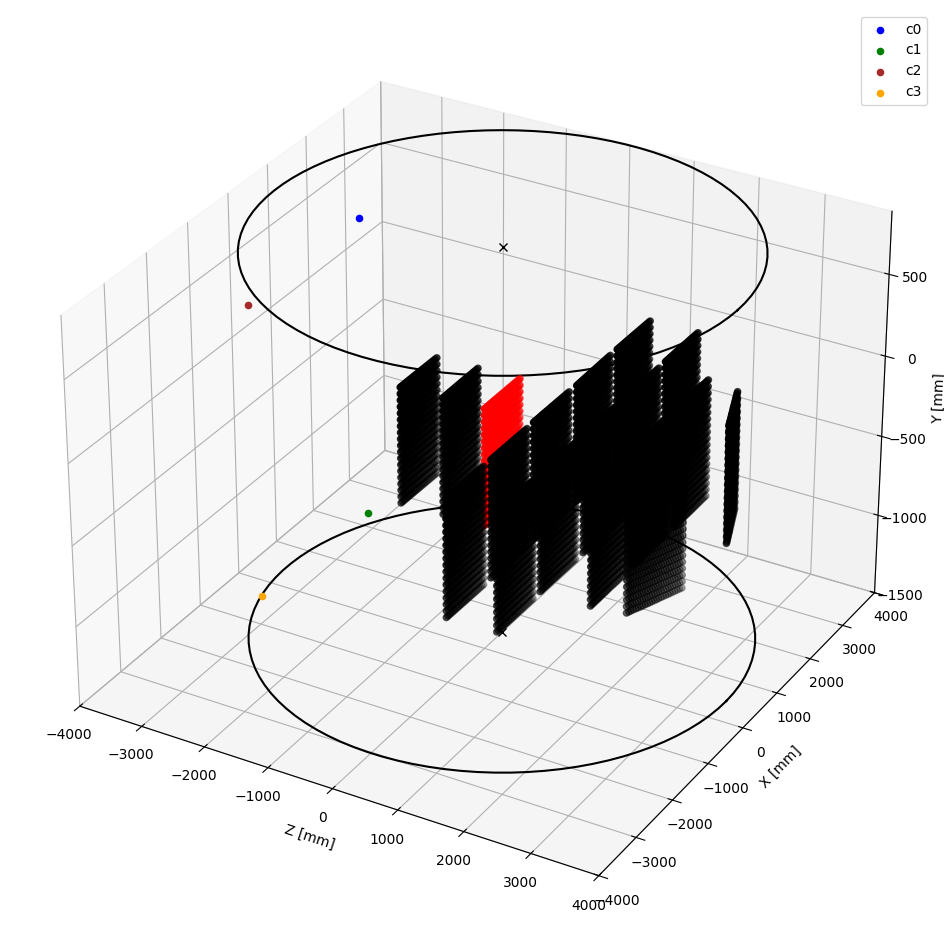

In [32]:

fig = plt.figure(figsize=(12,12))
axis = fig.add_subplot(111, projection='3d')
axis.set_xlabel('Z [mm]'), axis.set_ylabel('X [mm]'), axis.set_zlabel('Y [mm]')
axis.set_xlim(-4000,4000), axis.set_ylim(-4000,4000), axis.set_zlim(-1500,880) # 2.38 x 7.0 m , cameras about 20cm away from the bottom and top plate
axis.scatter(pos_c[0][2],pos_c[0][0],pos_c[0][1],label='c0',c='blue')  
axis.scatter(pos_c[1][2],pos_c[1][0],pos_c[1][1],label='c1',c='green')  
axis.scatter(pos_c[2][2],pos_c[2][0],pos_c[2][1],label='c2',c='brown')  
axis.scatter(pos_c[3][2],pos_c[3][0],pos_c[3][1],label='c3',c='orange')  
axis.scatter(XYZ[0][:,2],XYZ[0][:,0],XYZ[0][:,1],c='red')   
[axis.scatter(P[i][:,2],P[i][:,0],P[i][:,1],c='black') for i in range(1,len(params.planes))]
# plot geometry
theta = np.linspace(0, 2*np.pi, 100)
geometry_down = [3500*np.cos(theta),3500*np.sin(theta)+480,np.zeros_like(theta)-1500]
geometry_up = [3500*np.cos(theta),3500*np.sin(theta)+480,np.zeros_like(theta)+880]
axis.plot(geometry_down[0],geometry_down[1],geometry_down[2],c='black')
axis.plot(geometry_up[0],geometry_up[1],geometry_up[2],c='black')
axis.plot(0,480,-1500,'x',c='black')
axis.plot(0,480,880,'x',c='black')
plt.legend()
plt.show()

In [33]:
import numpy as np

import plotly.graph_objs as go

fig = go.Figure()

# Plot camera positions
fig.add_trace(go.Scatter3d(
    x=[pos_c[0][2]], y=[pos_c[0][0]], z=[pos_c[0][1]],
    mode='markers', marker=dict(size=8, color='blue'), name='c0'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[1][2]], y=[pos_c[1][0]], z=[pos_c[1][1]],
    mode='markers', marker=dict(size=8, color='green'), name='c1'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[2][2]], y=[pos_c[2][0]], z=[pos_c[2][1]],
    mode='markers', marker=dict(size=8, color='brown'), name='c2'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[3][2]], y=[pos_c[3][0]], z=[pos_c[3][1]],
    mode='markers', marker=dict(size=8, color='orange'), name='c3'
))

# Plot reference plane markers (red)
fig.add_trace(go.Scatter3d(
    x=XYZ[0][:,2], y=XYZ[0][:,0], z=XYZ[0][:,1],
    mode='markers', marker=dict(size=3, color='red'), name='Reference Plane'
))

# Plot all other planes (black)
for i in range(1, len(params.planes)):
    fig.add_trace(go.Scatter3d(
        x=P[i][:,2], y=P[i][:,0], z=P[i][:,1],
        mode='markers', marker=dict(size=2, color='black'), name=f'Plane {i}'
    ))

fig.add_trace(go.Scatter3d(
    x=geometry_down[0], y=geometry_down[1], z=geometry_down[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Down'
))
fig.add_trace(go.Scatter3d(
    x=geometry_up[0], y=geometry_up[1], z=geometry_up[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Up'
))

# Plot X marks for geometry
fig.add_trace(go.Scatter3d(
    x=[0], y=[480], z=[-1500],
    mode='markers', marker=dict(symbol='x', size=10, color='black'), name='Bottom Center'
))
fig.add_trace(go.Scatter3d(
    x=[0], y=[480], z=[880],
    mode='markers', marker=dict(symbol='x', size=10, color='black'), name='Top Center'
))

fig.update_layout(
    scene=dict(
        xaxis_title='Z [mm]',
        yaxis_title='X [mm]',
        zaxis_title='Y [mm]',
        xaxis=dict(range=[-4000, 4000]),
        yaxis=dict(range=[-4000, 4000]),
        zaxis=dict(range=[-1500, 880])
    ),
    legend=dict(itemsizing='constant'),
    width=900, height=900,
    title='3D Camera and Marker Geometry'
)

fig.show()

In [34]:
import numpy as np
import plotly.graph_objs as go

fig = go.Figure()

# Plot camera positions (x, y, z order)
fig.add_trace(go.Scatter3d(
    x=[pos_c[0][0]], y=[pos_c[0][1]], z=[pos_c[0][2]],
    mode='markers', marker=dict(size=8, color='blue'), name='c0'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[1][0]], y=[pos_c[1][1]], z=[pos_c[1][2]],
    mode='markers', marker=dict(size=8, color='green'), name='c1'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[2][0]], y=[pos_c[2][1]], z=[pos_c[2][2]],
    mode='markers', marker=dict(size=8, color='brown'), name='c2'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[3][0]], y=[pos_c[3][1]], z=[pos_c[3][2]],
    mode='markers', marker=dict(size=8, color='orange'), name='c3'
))

# Plot reference plane markers (red), assuming XYZ[0] is (N,3) with columns x,y,z
fig.add_trace(go.Scatter3d(
    x=XYZ[0][:,0], y=XYZ[0][:,1], z=XYZ[0][:,2],
    mode='markers', marker=dict(size=3, color='red'), name='Reference Plane'
))

# Plot all other planes (black)
for i in range(1, len(params.planes)):
    fig.add_trace(go.Scatter3d(
        x=P[i][:,0], y=P[i][:,1], z=P[i][:,2],
        mode='markers', marker=dict(size=2, color='black'), name=f'Plane {i}'
    ))

# Plot geometry (down and up circles)

# plot geometry
theta = np.linspace(0, 2*np.pi, 100)
geometry_down = [3500*np.cos(theta),np.zeros_like(theta)-1500, 3500*np.sin(theta)+480]
geometry_up = [3500*np.cos(theta),np.zeros_like(theta)+880, 3500*np.sin(theta)+480]


fig.add_trace(go.Scatter3d(
    x=geometry_down[0], y=geometry_down[1], z=geometry_down[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Down'
))
fig.add_trace(go.Scatter3d(
    x=geometry_up[0], y=geometry_up[1], z=geometry_up[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Up'
))

# Plot X marks for geometry (x, y, z order)
fig.add_trace(go.Scatter3d(
    x=[0], z=[480], y=[-1500],
    mode='markers', marker=dict(symbol='x', size=10, color='black'), name='Bottom Center'
))
fig.add_trace(go.Scatter3d(
    x=[0], z=[480], y=[880],
    mode='markers', marker=dict(symbol='x', size=10, color='black'), name='Top Center'
))

fig.update_layout(
    scene=dict(
        xaxis_title='x [mm]',
        yaxis_title='y [mm]',
        zaxis_title='z [mm]',
        xaxis=dict(range=[-4000, 4000]),
        yaxis=dict(range=[-1500, 880]),
        zaxis=dict(range=[-4000, 4000])
    ),
    legend=dict(itemsizing='constant'),
    width=900, height=900,
    title='3D Camera and Marker Geometry (Data Coordinate System)'
)

fig.show()


In [35]:
import numpy as np
from pathlib import Path



params = Parameter()
file_paths = []
for ci, cam in enumerate(params.cams):
        fname = params.markerOutput.format(cam=str(cam))
        file_paths.append(fname)
        if not Path(fname).exists():
            raise FileNotFoundError(f"File {fname} does not exist.")
            

In [36]:
file_paths

['c0_xyXYZ.txt', 'c1_xyXYZ.txt', 'c2_xyXYZ.txt', 'c3_xyXYZ.txt']

In [37]:
import pandas as pd
from functools import reduce
import plotly.express as p

with open(file_paths[0], 'r') as f:
    header = f.readline().lstrip('#').strip().split(',')

# Read all marker files into a list of DataFrames
data_list = []
for fp in file_paths[:4]:
    with open(fp, 'r') as f:
        header = f.readline().lstrip('#').strip().split(',')
    df = pd.read_csv(fp, sep='\s+', skiprows=1, names=[h.strip() for h in header])
    data_list.append(df)

# Merge on X, Y, Z (inner join, assuming these are the same across cameras)

# Add camera-specific x, y columns
for i, df in enumerate(data_list):
    df = df.rename(columns={'x': f'x_c{i}', 'y': f'y_c{i}'})
    data_list[i] = df[['X', 'Y', 'Z', f'x_c{i}', f'y_c{i}']]

# Merge all DataFrames on X, Y, Z
data = reduce(lambda left, right: pd.merge(left, right, on=['X', 'Y', 'Z'], how='inner'), data_list)

# Reorder columns: X, Y, Z, x_c0, y_c0, x_c1, y_c1, x_c2, y_c2, x_c3, y_c3
cols = ['X', 'Y', 'Z']
for i in range(4):
    cols.extend([f'x_c{i}', f'y_c{i}'])
data = data[cols]


data.head()
# print(data)

,X,Y,Z,x_c0,y_c0,x_c1,y_c1,x_c2,y_c2,x_c3,y_c3
0,0.0,0.0,0.0,672.120178,1304.126343,675.450439,1172.250732,1396.705078,1230.032837,1407.599854,1253.053833
1,40.0,0.0,0.0,690.242188,1302.604004,692.822998,1174.741943,1417.737061,1230.644653,1427.272949,1250.746582
2,80.0,0.0,0.0,708.933167,1301.033936,709.974731,1177.201538,1438.955200,1231.261963,1447.088257,1248.422729
3,120.0,0.0,0.0,727.349976,1299.486816,727.548645,1179.721558,1459.765747,1231.867432,1466.339111,1246.165161
4,160.0,0.0,0.0,745.939331,1297.925293,745.322632,1182.270386,1480.308228,1232.465088,1485.992920,1243.860229


In [38]:
import plotly.graph_objs as go

# Extract X, Y, Z columns
X = data['X']
Y = data['Y']
Z = data['Z']

fig = go.Figure()

# Plot camera positions (x, y, z order)
fig.add_trace(go.Scatter3d(
    x=[pos_c[0][0]], y=[pos_c[0][1]], z=[pos_c[0][2]],
    mode='markers', marker=dict(size=8, color='blue'), name='c0'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[1][0]], y=[pos_c[1][1]], z=[pos_c[1][2]],
    mode='markers', marker=dict(size=8, color='green'), name='c1'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[2][0]], y=[pos_c[2][1]], z=[pos_c[2][2]],
    mode='markers', marker=dict(size=8, color='brown'), name='c2'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[3][0]], y=[pos_c[3][1]], z=[pos_c[3][2]],
    mode='markers', marker=dict(size=8, color='orange'), name='c3'
))

# Plot reference plane markers (red), assuming XYZ[0] is (N,3) with columns x,y,z
fig.add_trace(go.Scatter3d(
    x=X, y=Y, z=Z,
    mode='markers', marker=dict(size=1, color='blue'), name = 'planes'
))

# Plot all other planes (black)
# for i in range(1, len(params.planes)):
#     fig.add_trace(go.Scatter3d(
#         x=P[i][:,0], y=P[i][:,1], z=P[i][:,2],
#         mode='markers', marker=dict(size=2, color='black'), name=f'Plane {i}'
#     ))

# Plot geometry (down and up circles)

# plot geometry
theta = np.linspace(0, 2*np.pi, 100)
geometry_down = [3500*np.cos(theta),np.zeros_like(theta)-1500, 3500*np.sin(theta)+480]
geometry_up = [3500*np.cos(theta),np.zeros_like(theta)+880, 3500*np.sin(theta)+480]


fig.add_trace(go.Scatter3d(
    x=geometry_down[0], y=geometry_down[1], z=geometry_down[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Down'
))
fig.add_trace(go.Scatter3d(
    x=geometry_up[0], y=geometry_up[1], z=geometry_up[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Up'
))

# Plot X marks for geometry (x, y, z order)
fig.add_trace(go.Scatter3d(
    x=[0], z=[480], y=[-1500],
    mode='markers', marker=dict(symbol='x', size=10, color='black'), name='Bottom Center'
))
fig.add_trace(go.Scatter3d(
    x=[0], z=[480], y=[880],
    mode='markers', marker=dict(symbol='x', size=10, color='black'), name='Top Center'
))

fig.update_layout(
    scene=dict(
        xaxis_title='x [mm]',
        yaxis_title='y [mm]',
        zaxis_title='z [mm]',
        xaxis=dict(range=[-4000, 4000]),
        yaxis=dict(range=[-1500, 880]),
        zaxis=dict(range=[-4000, 4000])
    ),
    legend=dict(itemsizing='constant'),
    width=900, height=900,
    title='3D Camera and Marker Geometry (Data Coordinate System)'
)

fig.show()

In [39]:
import numpy as np

def farthest_point_sampling(X, Y, Z, n_samples=10, seed=None):
    rng = np.random.default_rng(seed)
    points = np.stack([X.values, Y.values, Z.values], axis=1)
    n_points = points.shape[0]
    selected_indices = []
    # Start with a random point
    idx = rng.integers(n_points)
    selected_indices.append(idx)
    # Compute distances to the first point
    dists = np.linalg.norm(points - points[idx], axis=1)
    for _ in range(1, n_samples):
        idx = np.argmax(dists)
        selected_indices.append(idx)
        # Update distances: for each point, keep the minimum distance to any selected point
        dists = np.minimum(dists, np.linalg.norm(points - points[idx], axis=1))
    return selected_indices

# Example usage:
fps_indices = farthest_point_sampling(X, Y, Z, n_samples=40, seed=42)
sampled_fps = data.loc[fps_indices, [f'x_c{i}' for i in range(4)] + [f'y_c{i}' for i in range(4)] + ['X', 'Y', 'Z']]
sampled_fps

,x_c0,x_c1,x_c2,x_c3,y_c0,y_c1,y_c2,y_c3,X,Y,Z
763,745.671692,727.104675,1804.763306,1816.339722,964.565613,1090.757812,904.329102,1110.242065,504.278198,-442.671265,-645.746704
8099,1102.269775,1090.657104,1109.177490,1137.004639,1404.102051,892.146912,1367.883789,943.346375,-150.254456,15.515267,3101.160645
4774,2263.177246,2185.692627,2310.962646,2292.642334,1271.731812,1143.163086,1340.414185,958.998657,3268.918701,10.722355,1499.224976
4275,47.931717,71.259155,171.619843,276.534241,1397.940674,972.209351,1253.451538,1242.320923,-2284.854980,-5.350567,740.651184
5676,1380.305420,1388.500977,1647.665405,1670.147705,1070.787354,784.944580,1075.695557,767.951294,1200.957520,-709.101074,1514.237671
6160,739.887695,722.693665,970.725952,974.999634,1135.466797,726.588501,1039.662354,812.511230,-731.664429,-715.786438,1505.133301
7624,1721.906982,1684.629395,1738.863037,1741.997681,1354.895996,976.639221,1368.996216,915.617432,2038.634521,18.445786,2751.038086
1431,942.131653,932.335571,1409.393311,1421.315552,1332.274780,1082.130371,1284.314575,1125.257202,243.958969,1.285913,751.863831
3301,1836.004028,1867.762329,2176.482666,2220.144287,935.825073,877.104553,1028.671753,772.111572,2347.827148,-709.911133,764.301880
8525,837.560303,826.733826,857.641663,865.060547,1212.145020,686.185608,1131.900757,768.321289,-1043.551514,-712.457031,2760.152588


In [40]:
import plotly.graph_objs as go

# Plot all points in blue
fig = go.Figure()


fig.add_trace(go.Scatter3d(
    x=X, y=Y, z=Z,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='All Markers'
))

# Plot random sampled points (fps_indices) in red
sampled_fps = data.loc[fps_indices, ['X', 'Y', 'Z']]
fig.add_trace(go.Scatter3d(
    x=sampled_fps['X'], y=sampled_fps['Y'], z=sampled_fps['Z'],
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Random Sampled Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)'
    ),
    title='3D Scatter Plot with Random Sampled Points Highlighted'
)

# plot geometry
theta = np.linspace(0, 2*np.pi, 100)
geometry_down = [3500*np.cos(theta),np.zeros_like(theta)-1500, 3500*np.sin(theta)+480]
geometry_up = [3500*np.cos(theta),np.zeros_like(theta)+880, 3500*np.sin(theta)+480]


fig.add_trace(go.Scatter3d(
    x=geometry_down[0], y=geometry_down[1], z=geometry_down[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Down'
))
fig.add_trace(go.Scatter3d(
    x=geometry_up[0], y=geometry_up[1], z=geometry_up[2],
    mode='lines', line=dict(color='black', width=2), name='Geometry Up'
))

# Plot X marks for geometry (x, y, z order)
fig.add_trace(go.Scatter3d(
    x=[0], z=[480], y=[-1500],
    mode='markers', marker=dict(symbol='x', size=3, color='black'), name='Bottom Center'
))
fig.add_trace(go.Scatter3d(
    x=[0], z=[480], y=[880],
    mode='markers', marker=dict(symbol='x', size=3, color='black'), name='Top Center'
))

fig.update_layout(
    scene=dict(
        xaxis_title='x [mm]',
        yaxis_title='y [mm]',
        zaxis_title='z [mm]',
        xaxis=dict(range=[-4000, 4000]),
        yaxis=dict(range=[-1500, 880]),
        zaxis=dict(range=[-4000, 4000])
    ),
    legend=dict(itemsizing='constant'),
    width=900, height=900,
    title='3D Camera and Marker Geometry (Data Coordinate System)'
)

# Plot camera positions (x, y, z order)
fig.add_trace(go.Scatter3d(
    x=[pos_c[0][0]], y=[pos_c[0][1]], z=[pos_c[0][2]],
    mode='markers', marker=dict(size=8, color='blue'), name='c0'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[1][0]], y=[pos_c[1][1]], z=[pos_c[1][2]],
    mode='markers', marker=dict(size=8, color='green'), name='c1'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[2][0]], y=[pos_c[2][1]], z=[pos_c[2][2]],
    mode='markers', marker=dict(size=8, color='brown'), name='c2'
))
fig.add_trace(go.Scatter3d(
    x=[pos_c[3][0]], y=[pos_c[3][1]], z=[pos_c[3][2]],
    mode='markers', marker=dict(size=8, color='orange'), name='c3'
))

fig.show()

In [41]:
# Prepare data for saving: running index (0-based), X, Y, Z for fps_indices
calib_block = sampled_fps.reset_index(drop=True)
calib_block.insert(0, 'idx', range(len(calib_block)))

# Save to tab-delimited text file
calib_block[['idx', 'X', 'Y', 'Z']].to_csv('cal/new/calibration_block.txt', sep='\t', index=False, header=False, float_format='%.8f')

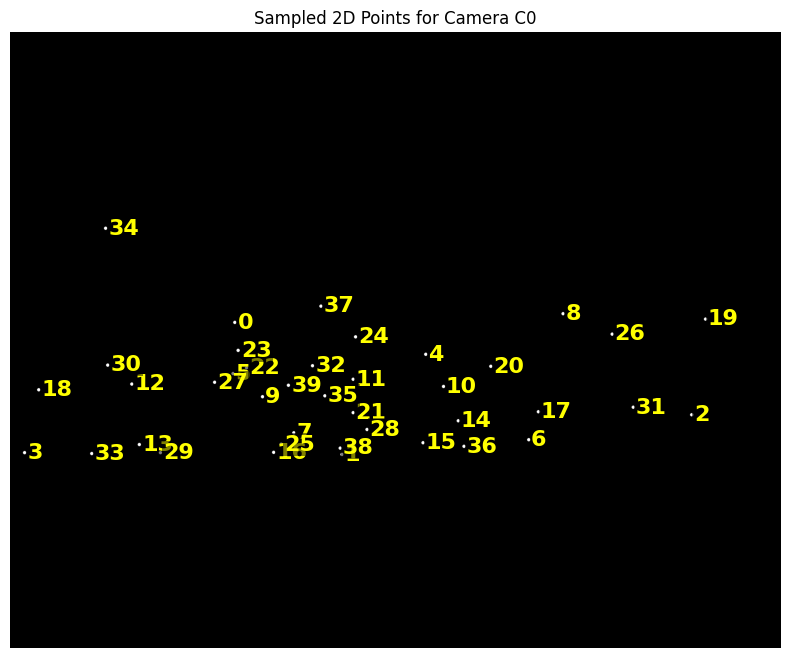

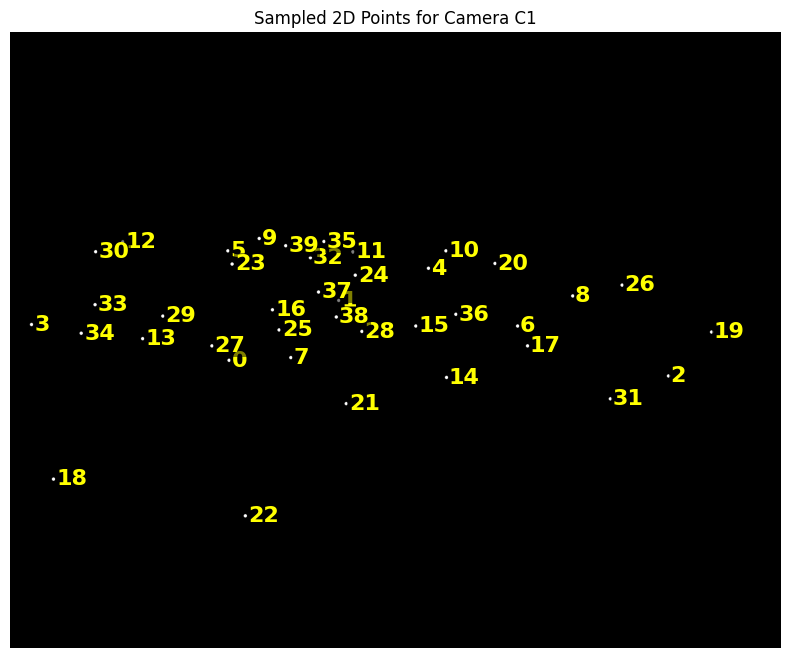

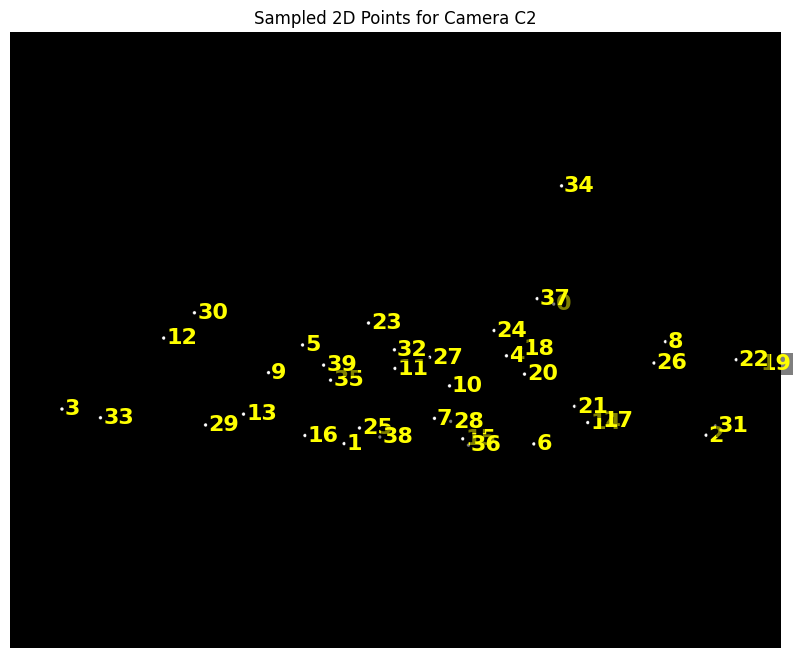

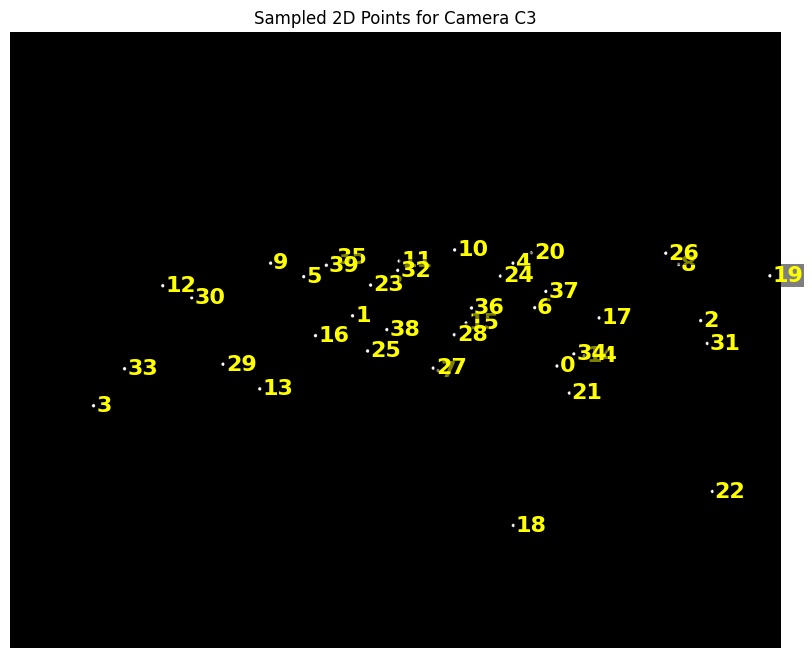

In [42]:
from PIL import Image, ImageDraw
import imageio.v3 as imageio
import matplotlib.pyplot as plt

# Camera names and corresponding columns
camera_names = ['c0', 'c1', 'c2', 'c3']

for i, cam in enumerate(camera_names):
    img = Image.new('L', (2560, 2048), 0)
    draw = ImageDraw.Draw(img)
    # Get x, y for this camera from sampled_fps indices
    xy_points = data.loc[fps_indices, [f'x_{cam}', f'y_{cam}']].values
    xy_points = np.round(xy_points).astype(int)
    for x, y in xy_points:
        if 0 <= x < 2560 and 0 <= y < 2048:
            draw.ellipse((x-5, y-5, x+5, y+5), fill=255)
    # Show image
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.title(f'Sampled 2D Points for Camera {cam.upper()}')
    plt.axis('off')
    # Add running number (idx) next to each point
    for j, (x, y) in enumerate(xy_points):
        plt.text(x + 10, y, str(j), color='yellow', fontsize=16, fontweight='bold', va='center', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
    plt.show()
    # Save image
    imageio.imwrite(f'./cal/new/cam{i+1}.tif', np.array(img))



In [43]:
# Provide the folder path where the file is located
pyptv_folder = Path.cwd() 
folder_path = pyptv_folder / 'res'  # Replace with the actual folder path
cal_path = pyptv_folder / 'cal'
ori_files = cal_path.rglob('*.ori')

# Construct the full file path
file_path = f'{folder_path}/rt_is.123456789'

# Read the file using numpy
data = np.loadtxt(file_path, skiprows=1)

import plotly.graph_objs as go
import plotly.express as px

# Filter the rows where the last column is not -1
filtered_data = data[np.sum(data[:, -4:] == -1, axis=1) < 3]

# Extract the columns for the 3D scatter plot from the filtered data
x = filtered_data[:, 1]
y = filtered_data[:, 2]
z = filtered_data[:, 3]



# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])

# Set plot title and labels
fig.update_layout(title='3D Scatter Plot', scene=dict(
    xaxis_title='Z',
    yaxis_title='X',
    zaxis_title='Y'
))


for f in ori_files:
    with open(f, 'r') as file:
        # Read the first line for camera position
        cam_pos = np.array(file.readline().strip().split(), dtype=float)
        # Read the second line for camera angles
        cam_angles = np.array(file.readline().strip().split(), dtype=float)
    
    # Calculate the direction vector from the angles
    direction = np.array([
        np.cos(cam_angles[1]) * np.cos(cam_angles[0]),
        np.sin(cam_angles[1]),
        np.cos(cam_angles[1]) * np.sin(cam_angles[0])
    ])
    
    # Plot the camera position
    fig.add_trace(go.Scatter3d(
        x=[cam_pos[0]], y=[cam_pos[1]], z=[cam_pos[2]],
        mode='markers',
        marker=dict(size=5, color='red'),
        name='Camera Position'
    ))
    
    # Plot the direction arrow
    fig.add_trace(go.Scatter3d(
        x=[cam_pos[0], cam_pos[0] + direction[0]],
        y=[cam_pos[1], cam_pos[1] + direction[1]],
        z=[cam_pos[2], cam_pos[2] + direction[2]],
        mode='lines',
        line=dict(color='red', width=5),
        name='Camera Direction'
    ))


fig.add_trace(go.Scatter3d(
    x=calib_block['X'],
    y=calib_block['Y'],
    z=calib_block['Z'],
    mode='markers+text',
    marker=dict(size=6, color='red', opacity=0.8),
    text=calib_block['idx'].astype(str),
    textposition='top center',
    name='Calibration Block Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5),  # view from above front-right
            up=dict(x=0, y=1, z=0),         # y is up
            center=dict(x=0, y=0, z=0)
        )
    ),
    title='3D Scatter Plot of Calibration Block Points with Indices'
)



# Show the plot
fig.show()


In [21]:
import plotly.graph_objs as go

# 3D scatter plot of calibration block points with idx labels
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=calib_block['X'],
    y=calib_block['Y'],
    z=calib_block['Z'],
    mode='markers+text',
    marker=dict(size=6, color='red'),
    text=calib_block['idx'].astype(str),
    textposition='top center',
    name='Calibration Block Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5),  # view from above front-right
            up=dict(x=0, y=1, z=0),         # y is up
            center=dict(x=0, y=0, z=0)
        )
    ),
    title='3D Scatter Plot of Calibration Block Points with Indices'
)

fig.show()

In [22]:
calib_block['X'],calib_block['Y'],calib_block['Z']

(0     504.278198
 1    -150.254456
 2    3268.918701
 3   -2284.854980
 4    1200.957520
 5    -731.664429
 6    2038.634521
 7     243.958969
 8    2347.827148
 9   -1043.551514
 Name: X, dtype: float64,
 0   -442.671265
 1     15.515267
 2     10.722355
 3     -5.350567
 4   -709.101074
 5   -715.786438
 6     18.445786
 7      1.285913
 8   -709.911133
 9   -712.457031
 Name: Y, dtype: float64,
 0    -645.746704
 1    3101.160645
 2    1499.224976
 3     740.651184
 4    1514.237671
 5    1505.133301
 6    2751.038086
 7     751.863831
 8     764.301880
 9    2760.152588
 Name: Z, dtype: float64)

In [23]:
calib_block, df 

(   idx            X           Y            Z
 0    0   504.278198 -442.671265  -645.746704
 1    1  -150.254456   15.515267  3101.160645
 2    2  3268.918701   10.722355  1499.224976
 3    3 -2284.854980   -5.350567   740.651184
 4    4  1200.957520 -709.101074  1514.237671
 5    5  -731.664429 -715.786438  1505.133301
 6    6  2038.634521   18.445786  2751.038086
 7    7   243.958969    1.285913   751.863831
 8    8  2347.827148 -709.911133   764.301880
 9    9 -1043.551514 -712.457031  2760.152588,
              x_c3         y_c3           X           Y            Z
 0     1407.599854  1253.053833    0.000000    0.000000     0.000000
 1     1427.272949  1250.746582   40.000000    0.000000     0.000000
 2     1447.088257  1248.422729   80.000000    0.000000     0.000000
 3     1466.339111  1246.165161  120.000000    0.000000     0.000000
 4     1485.992920  1243.860229  160.000000    0.000000     0.000000
 ...           ...          ...         ...         ...          ...
 8545  108

In [24]:
df  = pd.DataFrame.from_records(filtered_data,columns=['ID','X', 'Y', 'Z', 'i','j','k','l'])

In [25]:
from numpy import isclose

# Find the order of rows in df that matches the order of rows in calib_block based on X, Y, Z

order = []
for _, row in calib_block.iterrows():
    # Find the index in df where X, Y, Z match (allowing for floating point tolerance)
    mask = (isclose(df['X'], row['X'], atol=50)) & \
           (isclose(df['Y'], row['Y'], atol=50)) & \
           (isclose(df['Z'], row['Z'], atol=50))
    idxs = df[mask].index
    if len(idxs) > 0:
        order.append(idxs[0])
    else:
        order.append(None)  # or handle as needed

order  # This list gives the indices in df that match the order of calib_block

[0, 8, 3, 9, 4, 1, 2, 5, 7, 6]

In [26]:
# Reorder df according to the found order (ignoring None values)
df_ordered = df.loc[order].reset_index(drop=True)

# Compare the coordinates in calib_block and df_ordered
comparison = pd.DataFrame({
    'calib_X': calib_block['X'],
    'df_X': df_ordered['X'],
    'calib_Y': calib_block['Y'],
    'df_Y': df_ordered['Y'],
    'calib_Z': calib_block['Z'],
    'df_Z': df_ordered['Z']
})

# Calculate differences
comparison['diff_X'] = comparison['calib_X'] - comparison['df_X']
comparison['diff_Y'] = comparison['calib_Y'] - comparison['df_Y']
comparison['diff_Z'] = comparison['calib_Z'] - comparison['df_Z']

comparison

,calib_X,df_X,calib_Y,df_Y,calib_Z,df_Z,diff_X,diff_Y,diff_Z
0,504.278198,505.467,-442.671265,-442.581,-645.746704,-645.847,-1.188802,-0.090265,0.100296
1,-150.254456,-152.761,15.515267,13.270,3101.160645,3091.498,2.506544,2.245267,9.662645
2,3268.918701,3276.123,10.722355,11.872,1499.224976,1502.984,-7.204299,-1.149645,-3.759024
3,-2284.854980,-2288.981,-5.350567,-4.165,740.651184,748.798,4.126020,-1.185567,-8.146816
4,1200.957520,1196.789,-709.101074,-709.141,1514.237671,1511.881,4.168520,0.039926,2.356671
5,-731.664429,-728.605,-715.786438,-715.187,1505.133301,1500.968,-3.059429,-0.599438,4.165301
6,2038.634521,2034.258,18.445786,18.407,2751.038086,2745.852,4.376521,0.038786,5.186086
7,243.958969,241.505,1.285913,0.888,751.863831,751.316,2.453969,0.397913,0.547831
8,2347.827148,2347.457,-709.911133,-710.711,764.301880,768.192,0.370148,0.799867,-3.890120
9,-1043.551514,-1037.493,-712.457031,-712.391,2760.152588,2746.758,-6.058514,-0.066031,13.394588


In [27]:
import numpy as np

# Compute the sum of squared differences for X, Y, Z columns
squared_diffs = (calib_block[['X', 'Y', 'Z']].values - df_ordered[['X', 'Y', 'Z']].values) ** 2
ls_distance = np.sqrt(np.sum(squared_diffs))

print(f"Least squares distance between the two datasets: {ls_distance:.4f}")

Least squares distance between the two datasets: 24.3484
